<a href="https://colab.research.google.com/github/animesh/notebooks/blob/master/tfMGF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
*peptide spectra predictor*
- [Novo](https://github.com/nh2tran/DeepNovo)
- [Post](https://github.com/semiller10/postnovo)

In [1]:
#https://threader.app/thread/1105139360226140160
import tensorflow as tf
print(tf.__version__)
import datetime
print(datetime.datetime.now())
tf.keras.backend.clear_session() 
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print("Eager:",tf.executing_eagerly())
print("GPU:",tf.test.is_gpu_available())#:with tf.device("/gpu:0"):
#tf.keras.backend.clear_session()

def create_model():
  return tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
  ])

model = create_model()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

log_dir="/mnt/promec-ns9036k/.tools/exciting-wildebeest-tensorboard/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x=x_train,
          y=y_train,
          epochs=5,
          validation_data=(x_test, y_test),
          callbacks=[tensorboard_callback])

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

1.13.2
2019-10-08 14:25:27.201671
Eager: False
GPU: True
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 22s 372us/sample - loss: 0.2170 - acc: 0.9347 - val_loss: 0.1126 - val_acc: 0.9666
Epoch 2/5
60000/60000 [==============================] - 22s 359us/sample - loss: 0.0971 - acc: 0.9703 - val_loss: 0.0744 - val_acc: 0.9774
Epoch 3/5
60000/60000 [==============================] - 21s 348us/sample - loss: 0.0683 - acc: 0.9786 - val_loss: 0.0682 - val_acc: 0.9786
Epoch 4/5
60000/60000 [==============================] - 20s 336us/sample - loss: 0.0537 - acc: 0.9831 - val_loss: 0.0674 - val_acc: 0.9782
Epoch 5/5
60000/60000 [==============================] - 21s 351us/sample - loss: 0.0427 - acc: 0.9858 - val_loss: 0.0723 - val_acc: 0.9784


In [4]:
import numpy as np
def parseMGF(mgfData):
    data = mgfData.read_text().split('\n')
    _comments = '#;!/'
    reading_spectrum = False
    params = {}
    masses = []
    intensities = []
    charges = []
    out = {}
    cnt = 0
    pep_mass = 0
    pep_intensity = 0
    out = {}
    for line in data:
        if not reading_spectrum:
            if line.strip() == 'BEGIN IONS': reading_spectrum = True
        else:
            if not line.strip() or any(line.startswith(c) for c in _comments): pass
            elif line.strip() == 'END IONS':
                reading_spectrum = False
                title = params['title'].split()[0]
                if 'pepmass' in params:
                    try:
                        pl = params['pepmass'].split()
                        if len(pl) > 1:
                            pep_mass = float(pl[0])
                            pep_intensity = float(pl[1])
                        elif len(pl) == 1: pep_mass = float(pl[0])
                    except ValueError: print("Error in parsing pepmass value")
                out[cnt] = {'pep_mass': pep_mass,'pep_intensity': pep_intensity,'rtinseconds': params['rtinseconds'],'title': params['title'],'charge': params['charge'],'mz_array': np.array(masses),'intensity_array': np.array(intensities)}
                cnt += 1
            else:
                l = line.split('=', 1)
                if len(l) > 1: params[l[0].lower()] = l[1].strip()
                elif len(l) == 1:  # looks like a peak list ;)
                    l = line.split()
                    if len(l) >= 2000:
                        try:
                            masses.append(float(l[0]))
                            intensities.append(float(l[1]))
                        except ValueError:
                            print("Error in parsing line "+line)
    return out

In [5]:
import pathlib
#file = pathlib.Path.cwd().parent.rglob('*.MGF')
#file = pathlib.Path.home()/'mgf' / '190128_robin_WT_5.raw.centroid.MGF'
file = pathlib.Path.home()/'mgf' / '190128_robin_ 6' / '190128_robin_WT_5.mgf'
print(file.exists())#read_text().split(' '))
out=parseMGF(file)

True


In [18]:
X=[(out[k]['pep_mass']-1.00727647)*int(out[k]['charge'].split('+')[0]) for k, _ in out.items()]
X_mz1=np.array(X).reshape(-1, 1)
print(X_mz1.shape)

(57697, 1)


In [19]:
X=[(out[k]['pep_intensity']) for k, _ in out.items()]
X_int=np.array(X).reshape(-1, 1)
print(X_int.shape)

(57697, 1)


In [23]:
k=0
print(out[k],X_int[k],X_mz1[k])

{'pep_mass': 388.89426, 'pep_intensity': 20313.0957, 'rtinseconds': '0', 'title': '1', 'charge': '2+', 'mz_array': array([], dtype=float64), 'intensity_array': array([], dtype=float64)} [20313.0957] [775.77396706]


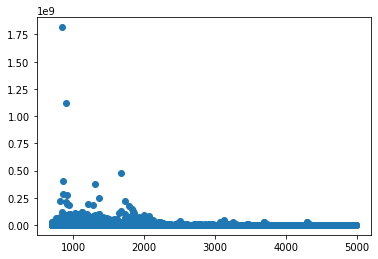

In [24]:
import matplotlib.pyplot as plt
#plt.hist(np.log2(X_mz1))
plt.scatter(X_mz1, X_int)

In [2]:
!pwd
#from  rulsif import RULSIF
#from cycler import cycler

/mnt/promec-ns9036k/NORSTORE_OSL_DISK/NS9036K/promec/promec/Animesh/notebooks


In [3]:
k = tf.placeholder(tf.float32)
# Make a normal distribution, with a shifting mean
mean_moving_normal = tf.random_normal(shape=[1000], mean=(5*k), stddev=1)
# Record that distribution into a histogram summary
tf.summary.histogram("normal/moving_mean", mean_moving_normal)

# Setup a session and summary writer
sess = tf.Session()
writer = tf.summary.FileWriter("/mnt/promec-ns9036k/.tools/ponderous-pug-tensorboard")

summaries = tf.summary.merge_all()

# Setup a loop and write the summaries to disk
N = 400
#for step in range(N):
#  k_val = step/float(N)
#  summ = sess.run(summaries, feed_dict={k: k_val})
#  writer.add_summary(summ, global_step=step)

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
features = tfp.distributions.Normal(loc=0., scale=1.).sample(int(100e3))
labels = tfp.distributions.Bernoulli(logits=1.618 * features).sample()
model = tfp.glm.Bernoulli()
coeffs, linear_response, is_converged, num_iter = tfp.glm.fit(
    model_matrix=features[:, tf.newaxis],
    response=tf.cast(labels, dtype=tf.float32),
    model=model)
print(coeffs, linear_response, is_converged, num_iter,model)

Tensor("fit_3/while/Exit_2:0", shape=(1,), dtype=float32) Tensor("fit_3/while/Exit_3:0", shape=(100000,), dtype=float32) Tensor("fit_3/while/Exit:0", shape=(), dtype=bool) Tensor("fit_3/while/Exit_1:0", shape=(), dtype=int32) tfp.glm.family.Bernoulli('Bernoulli_7/')


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(GaussianNoise(STD_DEV, input_shape=(MAX_WORDS, vectors.dim)))
model.add(Bidirectional(LSTM(HIDDEN_UNITS, activation='tanh'), merge_mode='concat'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Dense(num_outputs, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=LEARNING_RATE),
    metrics=['categorical_accuracy'])

NameError: name 'GaussianNoise' is not defined

In [14]:
import pandas as pd
import numpy as np
import os
import keras
import matplotlib.pyplot as plt
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam

In [15]:
base_model=keras.applications.xception.Xception(include_top=True, 
                                                weights='imagenet', 
                                                input_tensor=None, 
                                                input_shape=None, 
                                                pooling=None, 
                                                classes=1000)
x=base_model.output
#x=GlobalAveragePooling4D()(x)
x=Dense(1024,activation='relu')(x)
x=Dense(1024,activation='relu')(x)
x=Dense(512,activation='relu')(x)
preds=Dense(2,activation='softmax')(x)

In [7]:
model=Model(inputs=base_model.input,outputs=preds)

In [8]:
for layer in model.layers[:20]:    layer.trainable=False
for layer in model.layers[20:]:    layer.trainable=True

In [9]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=train_datagen.flow_from_directory('./subCellular',
                                                  target_size=(299,299),
                                                  color_mode='rgb',
                                                  batch_size=32,
                                                  class_mode='categorical', 
                                                  shuffle=True)
model.compile(optimizer='Adam',loss='categorical_crossentropy',
              metrics=['accuracy'])
step_size_train=train_generator.n//train_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,epochs=2)

Found 171096 images belonging to 2 classes.
Instructions for updating:
Use tf.cast instead.
Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_132/Assign (defined at /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'training/Adam/Variable_132/Assign', defined at:
  File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 539, in run_forever
    self._run_once()
  File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1775, in _run_once
    handle._run()
  File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/opt/conda/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/opt/conda/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-9-9496b30f9be3>", line 12, in <module>
    steps_per_epoch=step_size_train,epochs=2)
  File "/opt/conda/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training_generator.py", line 40, in fit_generator
    model._make_train_function()
  File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/opt/conda/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/keras/optimizers.py", line 487, in get_updates
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/opt/conda/lib/python3.7/site-packages/keras/optimizers.py", line 487, in <listcomp>
    ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
  File "/opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 704, in zeros
    return variable(v, dtype=dtype, name=name)
  File "/opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 402, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1395, in __init__
    constraint=constraint)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/variables.py", line 1547, in _init_from_args
    validate_shape=validate_shape).op
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/state_ops.py", line 223, in assign
    validate_shape=validate_shape)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 64, in assign
    use_locking=use_locking, name=name)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[2048] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node training/Adam/Variable_132/Assign (defined at /opt/conda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:402) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
model.save('modelMGF.h5')    
!bzip2 'modelMGF.h5'

In [ ]:
import keras
config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 16} ) 
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [2]:
def parseMGF(mgfData):
    data = mgfData.read_text().split('\n')
    _comments = '#;!/'
    reading_spectrum = False
    params = {}
    masses = []
    intensities = []
    charges = []
    out = {}
    cnt = 0
    pep_mass = 0
    pep_intensity = 0
    out = {}
    for line in data:
        if not reading_spectrum:
            if line.strip() == 'BEGIN IONS': reading_spectrum = True
        else:
            if not line.strip() or any(line.startswith(c) for c in _comments): pass
            elif line.strip() == 'END IONS':
                reading_spectrum = False
                title = params['title'].split()[0]
                if 'pepmass' in params:
                    try:
                        pl = params['pepmass'].split()
                        if len(pl) > 1:
                            pep_mass = float(pl[0])
                            pep_intensity = float(pl[1])
                        elif len(pl) == 1: pep_mass = float(pl[0])
                    except ValueError: print("Error in parsing pepmass value")
                out[cnt] = {'pep_mass': pep_mass,'pep_intensity': pep_intensity,'rtinseconds': params['rtinseconds'],'title': params['title'],'charge': params['charge'],'mz_array': np.array(masses),'intensity_array': np.array(intensities)}
                cnt += 1
            else:
                l = line.split('=', 1)
                if len(l) > 1: params[l[0].lower()] = l[1].strip()
                elif len(l) == 1:  # looks like a peak list ;)
                    l = line.split()
                    if len(l) >= 2000:
                        try:
                            masses.append(float(l[0]))
                            intensities.append(float(l[1]))
                        except ValueError:
                            print("Error in parsing line "+line)
    return out

In [ ]:
import pandas as pd
# import formatter as fm
df = pd.read_csv('Groups.txt',sep='\t')
df.head()

In [ ]:
#check also https://github.com/kusterlab/prosit/blob/master/prosit/prediction.py

In [ ]:
!mkdir  ~/.kaggle
!cp $PWD/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -lthr ~/.kaggle/

In [ ]:
#!$HOME/.local/bin/kaggle datasets download -d piotrgrabo/breastcancerproteomes --force
!$HOME/.local/bin/kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
!find $HOME -iname train

In [ ]:
!pip install -U -q PyDrive --user
!pip install -U -q google.colab --user

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
model.save('model.h5')    
model_file = drive.CreateFile({'title' : 'model.h5'})
model_file.SetContentFile('model.h5')
model_file.Upload()
drive.CreateFile({'id': model_file.get('id')})

In [ ]:
!ls -ltrh

In [ ]:
outvec=[1 if 'positive' in i.parts[-2] else 0 for i in trainlist]
outvec

In [ ]:
outvecclip=outvec[0:99]

In [ ]:
(outvecclip)

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(MGF, binary_labels, test_size = .2)

In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=71, shuffle=True, random_state=42)
batches = [train for test, train  in kf.split(X_train, y_train)]
batches[0].shape

In [ ]:
kf = KFold(n_splits=10, shuffle=True, random_state=42)
test_batches = [t_batch for _, t_batch  in kf.split(X_test, y_test)]
np.histogram(test_batches[9])

In [ ]:
X_train.shape,X_test.shape

In [ ]:
predictions = [result for p in pred for result in p ]
predictions

In [ ]:
from  sklearn.metrics import accuracy_score,log_loss #ytrue ypred
log_loss(y_test, [[p[0],1-p[0]] for p in predictions])

In [ ]:
np.round([p[0] for p in predictions])

In [ ]:
# Compute confusion matrix
confusion_matrix([0, 1, 0, 1], [1, 1, 1, 0])
cnf_matrix = confusion_matrix(y_test, np.round([p[0] for p in predictions]))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['No Findings', 'Abnormal Findings'],
                      normalize=True,
                      title='Normalized confusion matrix')

plt.show()